# Classification and Regression Diffusion (CARD) Model

## Theoretic Foundation

## Outline

We will begin with a standard toy regression example and show you you can quantify uncertainty with the CARD approach. For this we will place a Gaussian Assumption on the model, which is not theoretical necessary but can be useful when comparing it for a standard toy regression problem. However, we will also show an example that demonstrates the expressiveness of CARD by reproducing the Donut example (Figure 1) from the original paper by [Han et al. 2022](https://arxiv.org/abs/2206.07275), which shows the strong capabilities of recovering the true data distribution.

In [ ]:
%%capture
%pip install lightning-uq-box

## Imports

In [1]:
import os
import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import (
    ToyDonutDataModule,
    ToyHeteroscedasticDatamodule,
)
from lightning_uq_box.models import MLP, ConditionalGuidedLinearModel
from lightning_uq_box.uq_methods import CARDRegression, DeterministicRegression
from lightning_uq_box.viz_utils import (
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

%load_ext autoreload
%autoreload 2

In [2]:
seed_everything(0)  # seed everything for reproducibility
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device

Seed set to 0


In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

In [4]:
dm = ToyHeteroscedasticDatamodule(n_points=1000)

X_train, Y_train, train_loader, X_test, Y_test, test_loader = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
)

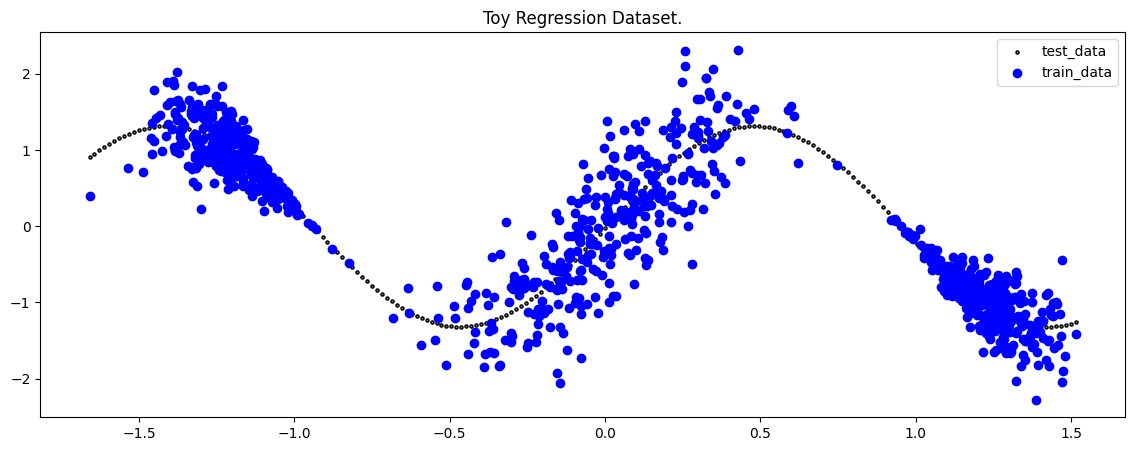

In [5]:
fig = plot_toy_regression_data(X_train, Y_train, X_test, Y_test)

# Model

For CARD, we need to pretrain a conditional mean estimation model before moving to diffusion training stage. Here, we will do this with a simple MLP and train it using the `DeterminisitcRegression` module.


In [8]:
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=tempfile.mkdtemp(),
)
trainer.fit(cond_mean_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.7 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'tr

We can plot the predictions of the pretrained model, which as a deterministic point network has no uncertainty estimate for its predictions.

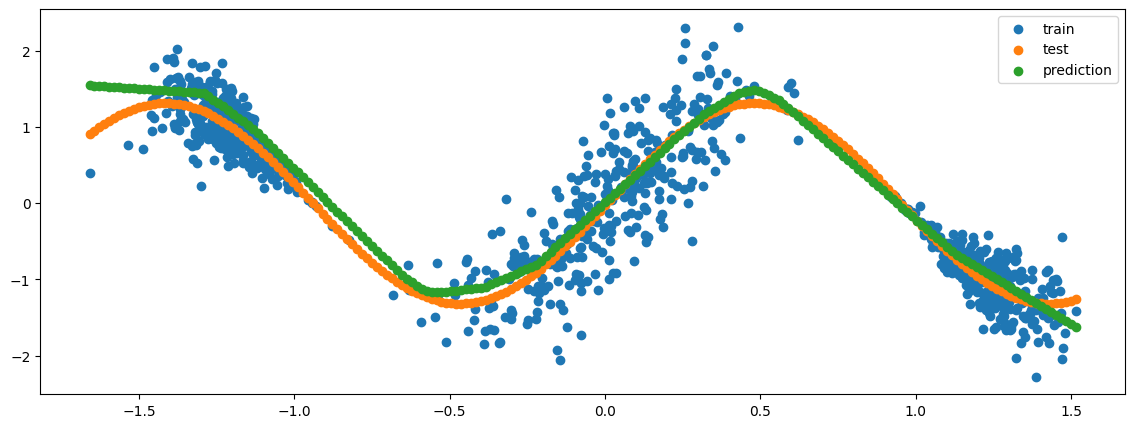

In [9]:
preds = cond_mean_model.predict_step(X_test)
fig, ax = plt.subplots(1)
ax.scatter(X_train, Y_train, label="train")
ax.scatter(X_test, Y_test, label="test")
ax.scatter(X_test, preds["pred"], label="prediction")
plt.legend()

## Diffusion Model

Given the deterministic conditional mean model, we can now move towards the diffusion modelling stage. For the guidance model we also select a simple Linear model.

In [10]:
# configuration parameters

n_steps = 1000
cat_x = True  # condition on input x through concatenation
cat_y_pred = True  # condition on y_0_hat

x_dim = 1
y_dim = 1

n_hidden = [128, 128]

beta_schedule = "linear"
beta_start = 0.0001
beta_end = 0.02

In [11]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=n_hidden,
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

In [12]:
card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    beta_schedule=beta_schedule,
    beta_start=beta_start,
    beta_end=beta_end,
    n_steps=n_steps,
)

> **_NOTE:_**  Dffusion modelling is computationally heavier than many other approaches, and is best done on a GPU. You can open this notebook in a google colab environment to access a GPU and experiment yourself (rocket icon button at top of the page).

In [14]:
logger = CSVLogger(my_temp_dir)
diff_trainer = Trainer(
    max_epochs=1000,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_progress_bar=False,
    default_root_dir=my_temp_dir,
)
diff_trainer.fit(card_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-------------------------------

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=1000` reached.


## Training metrics

We can check the convergence by inspecting the loss over epochs

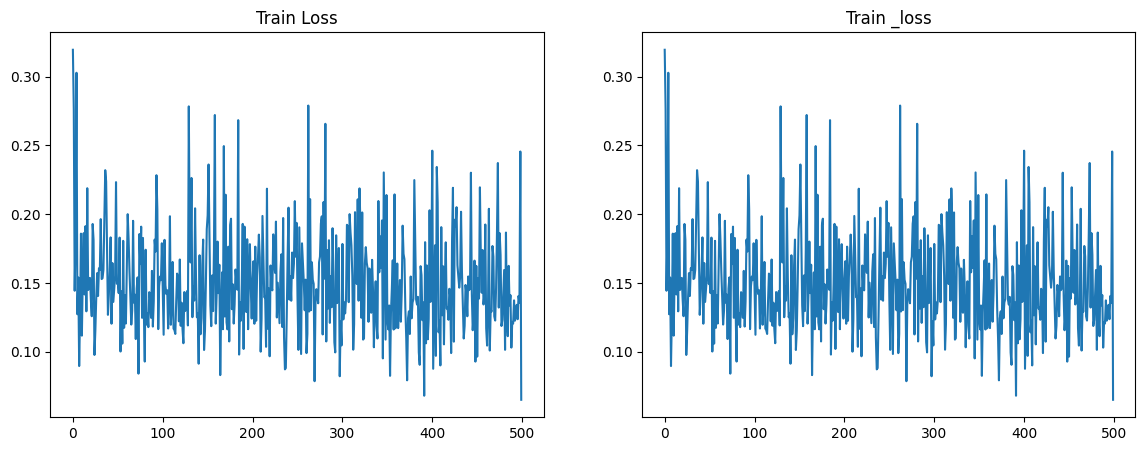

In [15]:
fig = plot_training_metrics(
    os.path.join(my_temp_dir, "lightning_logs"), ["train_loss", "trainRMSE"]
)

# Prediction

In [16]:
card_model = card_model.to("cuda")
preds = card_model.predict_step(X_test.cuda())

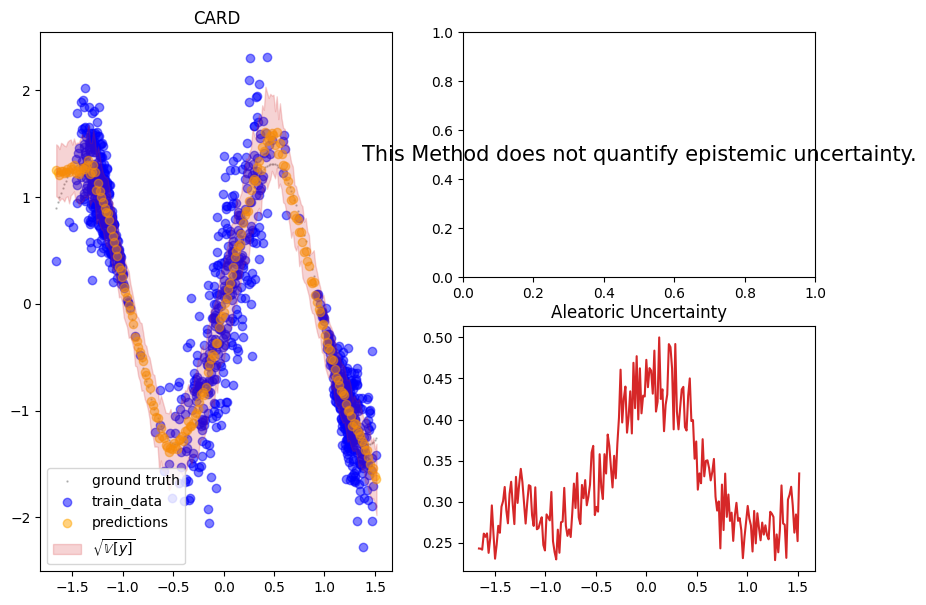

In [17]:
fig = plot_predictions_regression(
    X_train,
    Y_train,
    X_test,
    Y_test,
    preds["pred"],
    preds["pred_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="CARD",
    show_bands=False,
)

In this example, we placed a Gaussian assumption on the model outputs, as we did moment matching of the CARD samples to get an estimate of predictive uncertainty. This is restrictive and theoretically not necessary for CARD. We will demonstrate this with another example, the Donut toy example. The majority of UQ-Methods won't be able to solve this task as they inherently have a Gaussian assumption for their predictive uncertainty estimates, so this is a nice example of CARD's capabilities.

## Toy Donut example

## Datamodule

In [18]:
dm = ToyDonutDataModule(batch_size=256, n_samples=8096)

X_train, Y_train, train_loader, X_test, Y_test, test_loader = (
    dm.X_train,
    dm.Y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.Y_test,
    dm.test_dataloader(),
)

In [19]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([8096, 1]),
 torch.Size([8096, 1]),
 torch.Size([3238, 1]),
 torch.Size([3238, 1]))

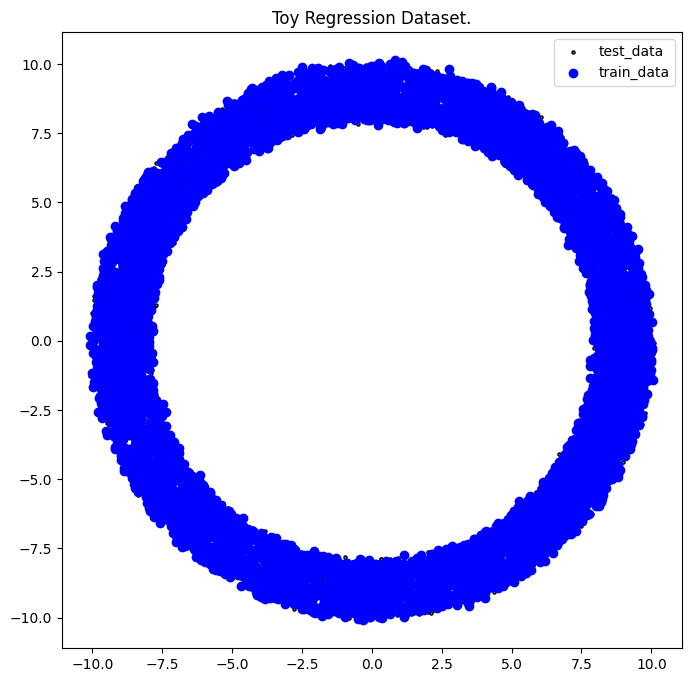

In [20]:
plt.rcParams["figure.figsize"] = [8, 8]
plot_toy_regression_data(X_train, Y_train, X_test, Y_test)
plt.rcParams["figure.figsize"] = [14, 5]

# Training

Fitting a deterministic base model.

In [22]:
another_temp_dir = tempfile.mkdtemp()
network = MLP(n_inputs=1, n_hidden=[50, 50], n_outputs=1)

cond_mean_model = DeterministicRegression(
    model=network, optimizer=partial(torch.optim.Adam, lr=1e-2), loss_fn=nn.MSELoss()
)

trainer = Trainer(
    max_epochs=100,  # number of epochs we want to train
    devices=[0],
    accelerator="gpu",
    enable_checkpointing=False,
    enable_progress_bar=False,
)
trainer.fit(cond_mean_model, dm)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.7 K 
1 | loss_fn       | MSELoss          | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total par

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=100` reached.


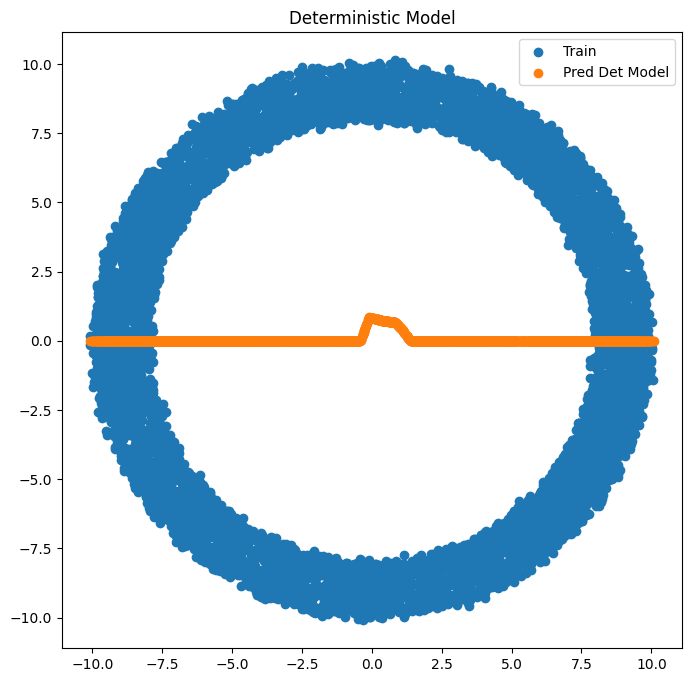

In [23]:
fig, axs = plt.subplots(1, figsize=(8, 8))

axs.scatter(X_train, Y_train, label="Train")
axs.scatter(
    X_test.detach().cpu().numpy(),
    network(X_test).detach().cpu().numpy(),
    label="Pred Det Model",
)
axs.set_title("Deterministic Model")
plt.legend()

We can see how a standard neural network cannot fit the data at all, but will now explore the capabilities of CARD.

In [24]:
guidance_model = ConditionalGuidedLinearModel(
    n_steps=n_steps,
    x_dim=x_dim,
    y_dim=y_dim,
    n_hidden=[128, 128],
    cat_x=cat_x,
    cat_y_pred=cat_y_pred,
)

card_model = CARDRegression(
    cond_mean_model=cond_mean_model.model,
    guidance_model=guidance_model,
    guidance_optim=partial(torch.optim.Adam, lr=1e-2),
    n_steps=n_steps,
)

In [25]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
logger = CSVLogger(another_temp_dir)
diff_trainer = Trainer(
    max_epochs=500,  # number of epochs we want to train
    accelerator="gpu",
    devices=[0],
    logger=logger,
    log_every_n_steps=4,
    enable_progress_bar=True,
    limit_val_batches=0.0,
)
diff_trainer.fit(card_model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: /tmp/tmpwn5ayqi0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                         | Params
-----------------------------------------------------------------
0 | cond_mean_model | MLP                          | 2.7 K 
1 | guidance_model  | ConditionalGuidedLinearModel | 273 K 
2 | train_metrics   | MetricCollection             | 0     
3 | val_metrics     | MetricCollection             | 0     
4 | test_metrics    | MetricCollection             | 0     
-----------------------------------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.103     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


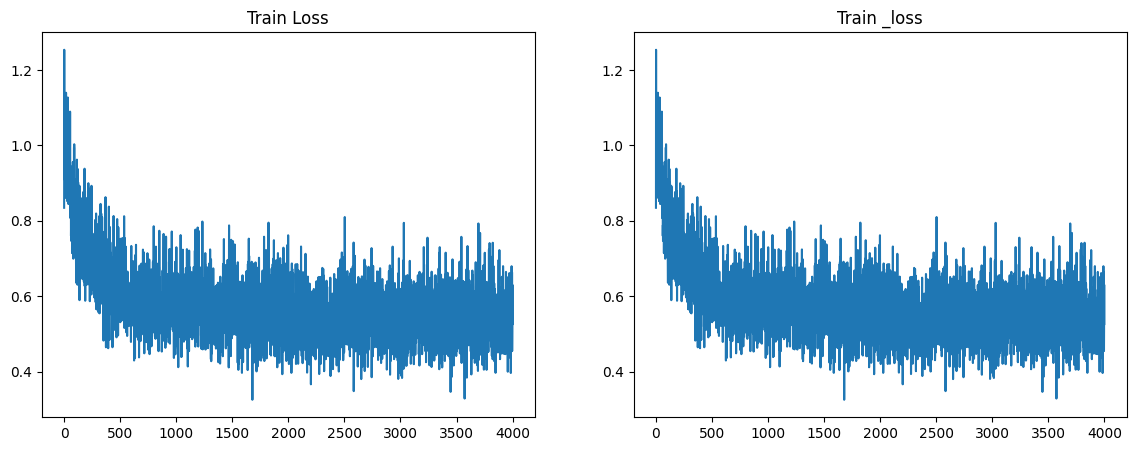

In [26]:
fig = plot_training_metrics(os.path.join(another_temp_dir, "lightning_logs"), "_loss")

## Prediction

We will now plot the generate samples of the Diffusion model to demonstrate how it actually recovers the 8 Gaussian bumps.

In [27]:
card_model = card_model.to("cuda")
preds = card_model.predict_step(X_test.cuda())

# samples of the last diffusion step which should recover the data distribution (n_samples, n_test_points, y_dim)
samples = preds["samples"][-1].detach().cpu().numpy()

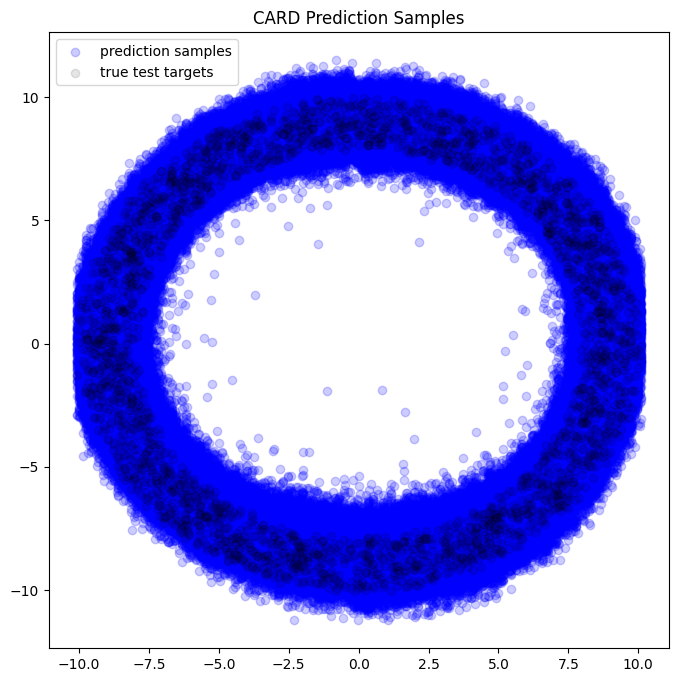

In [28]:
fig, axs = plt.subplots(1, figsize=(8, 8))


axs.scatter(
    X_test.tile(dims=(card_model.n_z_samples, 1)),
    samples.squeeze(),
    alpha=0.2,
    color="blue",
    label="prediction samples",
)
axs.scatter(X_test, Y_test, label="true test targets", alpha=0.1, color="black")
axs.set_title("CARD Prediction Samples")
plt.legend()

We can see that CARD can recover the underlying data distribution quiet well, which is quiet powerful.